# Manuela Quiroga Pérez - David Román Arboleda, curso de Análisis de Secuencias


El presente proyecto pretende recrear la metodología de procesamiento de secuencias crudas empleada por la tesis de doctorado “Estudio de la diversidad microbiana asociadas a suelos cacaoteros con presencia de cadmio (Cd) y evaluación de su potencial biorremediador” en la que se examinó la composición taxonómica de las comunidades bacterianas de fincas cacaoteras localizadas en Santander, Colombia, empleando secuenciación del gen ARN ribosomal 16S, usando la plataforma Illumina Miseq. 2 x 250 pb. Dicho procesamiento de las secuencias obtenidas se realizó usando el programa QIIME 2.0; sin embargo, a la fecha se han realizado diferentes actualizaciones del programa, lo cual permite trabajar más eficientemente los datos y, por lo tanto, obtener unos resultados diferentes que podrán ser comparados.

QIIME2 es un ambiente de cómputo para procesar y analizar los datos de amplicones. Generalmente, estos amplicones son generados a partir del gen rARN 16S en una comunidad procariótica, para poder tener una noción de las taxa presentes en las muestras y sus abundancias relativas. QIIME2 es un sistema en el que muchos análisis con diferentes plugins pueden operar, muchos de los cuales no son diseñados por los desarroladores de QIIME2. Hay muchos *workflows* mediante los cuales se puede procesar los metadatos obtenidos de una secuenciación, según la necesidad del usuario y las propiedades de los datos a tratar (Bolyen et al., 2018). En el presente trabajo se mostrará un *workflow* para el trato de datos single end del rARN 16S. 

## Búsqueda de datos y su descarga

Las secuencias fueron obtenidas de la tesis de doctorado de Pedro Felipe Feria Cáceres “Estudio de la diversidad microbiana asociadas a suelos cacaoteros con presencia de cadmio (Cd) y evaluación de su potencial biorremediador”. En dicho trabajo se obtuvieron datos crudos de secuencias 16S amplificadas, las cuales fueron depositadas y están disponibles en el NCBI bajo el BioProject ID SUB6627411 con Sequence Reads Archive (SRA) número de acceso PRJNA599345. Debido a que las secuencias fueron todas agrupadas en un solo archivo, los datos a analizar no son *paired end reads*, sino que son *single end*. Adicionalmente, la región del 16S que fue analizada en este trabajo fue la región V3-V4. El archivo obtenido fue sra_data.fastq.gz, que tenía un total de 591M bases, y un tamaño de 264.7Mb.

## Definir el *pipeline* apropiado para el manejo de datos

- *Prerrequisitos*: este tutorial utiliza la versión de QIIME2 qiime2-2021.2. A continuación se mostrará el proceso de instalación del programa y las versiones utilizadas para ello:

Haciendo uso del servidor del supercomputador APOLO, se cargaron los módulos de Python 3.7 y miniconda-4.8.3, para la creación de un ambiente dentro de miniconda y  la posterior instalación de QIIME2.


In [ ]:
module load python/3.9_miniconda-4.9.2
conda create -n qiime2.2021.2
conda activate qiime2.2021.2
conda install -c qiime2/label/r2021.2 qiime2

- *Overview* del flujo de trabajo en QIIME2:

En la Figura 1. se puede observar el flujo de trabajo utilizado para el análisis de las secuencias. Ya que se contaba con un archivo que agrupaba todas las secuencias obtenidas a partir de Illumina, los datos son tratados como single ends e inmediatamente se hace el demultiplexado pasan a ser procesados con DADA2 en un proceso de denoising.


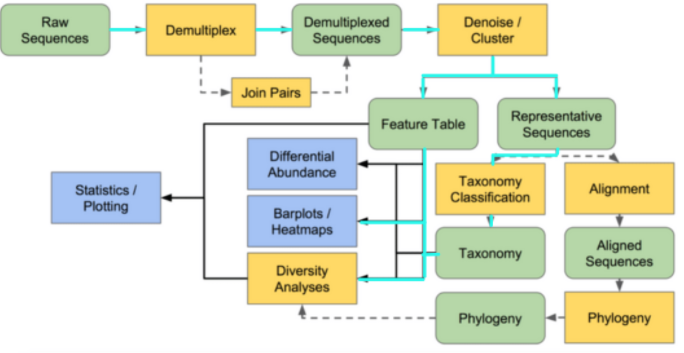
*Figura 1*. Flujo de trabajo seguido haciendo uso de los plugins de QIIME2. Señalado en azul está el camino seguido para la preparación y análisis de los datos. 

## Importe de datos

Para realizar el análisis de los datos en QIIME2 es necesario importar los datos en formato QIIME para que estos puedan ser leídos por el programa. En nuestro caso nosotros tenemos unos datos agrupados, *single end*, y multiplexados, que deben pasar por un procesamiento en QIIME2 para poder continuar con los siguientes pasos. 

In [ ]:
qiime tools import  --type MultiplexedSingleEndBarcodeInSequence --input-path Workdir/sra_data.fastq.gz --output-path multiplexed-seqs.qza

Es importante a la hora de importar los datos, tener en cuenta el tipo de datos con los que se está trabajando, pues esto hay que especificarlo en el parámetro *type* del comando dado. 

## De-multiplexado 

Las lecturas crudas brindadas consisten en *single end reads* almacenadas todas en un solo archivo. Debido a esto lo primero que se realizó fue una de-multiplexación para asociar cada *read* con su respectivo código de barras. Dentro de QIIME2 existe un *plug in* llamado cutadapt que nos permite realizar la de-multiplexación y al mismo tiempo la extracción de adaptadores y posibles *primers* que se encuentren en las secuencias como producto de la secuenciación. No obstante este es solo una de las opciones para la de-multiplexación de los datos, como ejercicio comparativo también empleamos el programa fastq-multx que hace parte de un conjunto de herramientas para trabajar con archivos fastq con el nombre de ea-utils.
Ambos programas necesitan dos archivos de entrada para llevar a cabo la de-multiplexación: un archivo de texto con las secuencias y otro archivo de texto con los códigos de barras que se asocian a estas secuencias, además el proceso de-multiplexación en ambos programas es básicamente igual al tener como objetivo el separar *reads* de diferentes muestras que se encuentran en un solo archivo. Al contrario el formato de salida es bastante diferente ya que además de la de-multiplexación, el *plug in* cutadapt corta los adaptadores y *primers* que se puedan encontrar en las secuencias, generando dos salidas: las secuencias en un archivo .qza de-multiplexadas y las mismas sin cortar los adaptadores. Por otro lado las salidas  fastq-multx dan lugar a múltiples archivos de texto formato fastq nombrados según el id del código de barras asociado a cada *read*.
Para la des-multiplexación con fastq-multx usando un valor de 1 en -m para establecer el número máximo de errores permitidos en los códigos de barra, agregando -x para no recortar los códigos de barra y -B para asignar el archivo que contiene los códigos de barra, dejando la línea de comando:

In [ ]:
fastq-multx -m1 -d1 -x -l barcodes2.txt WorkDir/sra_data.fastq.gz -o run2.%.fastq.gz

Como resultado se obtuvo un total de 751,991 reads diferentes. Por otro lado la línea de comando para la de-multiplexación con cutadapt es la siguiente: 

In [ ]:
qiime cutadapt demux-single --i-seqs multiplexed-seqs.qza --m-barcodes-file barcodes2.txt --m-barcodes-column barcode --p-error-rate 0 --o-per-sample-sequences demultiplexed-seqs.qza --o-untrimmed-sequences untrimmed.qza --verbose


En la cuál se puede escoger de igual forma el error mínimo, en este caso 0, y arrojó como resultado un total de 779,681 *reads*, un valor mayor que el de fastq-multx por 27,690 reads. Al comparar estos resultados con los *reads* obtenidos en el trabajo de grado que fueron 443,464, se ve un aumento de casi el doble en el número de *reads*, este desfase puede ser debido a el tratamiento de los datos y la rigurosidad con la que haya sido filtrados, además de su naturaleza ya que en nuestro caso las secuencias son *single end* mientras que las usadas en la tesis son de *pair end*, es decir, cuentan con la información de la secuencia *forward* y *reverse* permitiendo que se filtren de mejor manera los *reads* reales y se separen de los posibles errores de secuenciación al corroborar la secuencia en el otro segmento. De igual forma cabe resaltar que el número de *reads* no es proporcional al número de grupos que se generen posteriormente en la clasificación de dichos *reads*. 

## Denoising

Las secuencias obtenidas deben pasar por un proceso de denoising, en el que las secuencias se agrupan en Amplicon Sequence Variants (ASV’s), según la similitud de los datos. El denoising permite discriminar entre la diversidad verdadera de las secuencias y los errores de secuenciación. Se parte de las secuencias single end demultiplexadas y sin los barcodes/adapters, que han sido previamente removidos. El producto final es, entonces, una tabla de ASV, cuya resolución es mayor que la tabla tradicional de OTUs, en la cuál queda establecida el número de veces que cada ASV exacto fue observado en cada muestra; adicionalmente, se le asigna una taxonomía a las secuencias obtenidas.
Para lo anterior utilizamos DADA2, una herramienta que ya viene previamente instalada al interior de QIIME2, con el siguiente comando:

In [ ]:
qiime dada2 denoise-single --i-demultiplexed-seqs demultiplexed-seqs.qza --p-trim-left 13 --p-trunc-len 150 --o-representative-sequences representative_seqs.qza --o-table pet-table.qza --o-denoising-stats denoise_STATS.qza

Se puede observar que la calidad de las secuencias suele ser más bajas en las primeras 10 bases más o menos, por lo que se utiliza el parámetro --p-trim-left 13, para cortar las primeras 13 bases y se cortan las secuencias al alcanzar 150 bp utilizando el parámetro --p-trun-len 150. 
Para lo anterior debe proporcionarse el archivo demultiplexed-seqs.qza, previamente procesado. Al final obtendremos un archivo con las secuencias representativas que corresponden a cada ASV que se obtuvieron luego de realizar el filtro y la corrección de errores, llamado representative_seqs.qza; también se obtendrá un tabla de los ASV obtenidos: una matriz en los que cada línea corresponde a las muestras evaluadas y cada columna corresponde a los ASV, en los que el valor de cada entrada es el número de veces que un ASV es observado en la muestra específica, llamada pet-table.qza; y finalmente, se obtienen también las estadísticas del proceso de denoising llamadas denoise_STATS.qza.
Los archivos obtenidos están en formato .qza, por lo que se hace uso de los siguientes comandos para transformarlos en archivos .qzv que puedan ser abiertos por el visualizador de QIIME2 (https://view.qiime2.org/).

In [ ]:
qiime metadata tabulate \
--m-input-file denoise_STATS.qza \
--o-visualization metadata_STATS.qzv
qiime feature-table tabulate-seqs \
--i-data rep-seqs.qza \
--o-visualization rep-seqs.qzv

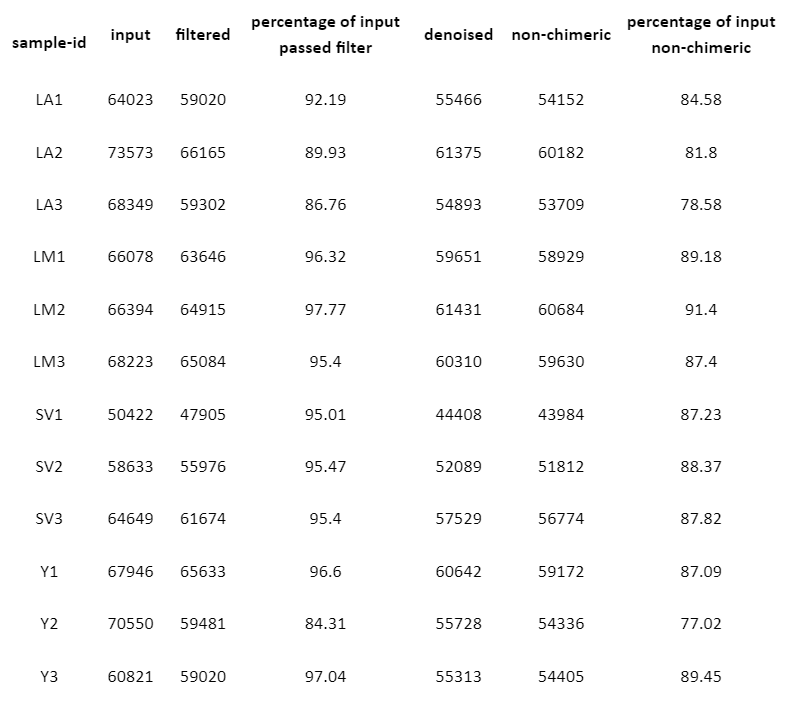
Tabla 1. Secuencias filtradas con DADA2, según la muestra, secuencias que pasaron por proceso de denoising y porcentajes de secuencias que pasaron los parámetros indicados

En la Tabla 1 se puede observar que las muestras tuvieron un porcentaje bastante alto de secuencias que pasaron el filtro de errores, lo que permite trabajar con un número de secuencias más robusto y significativo, a la hora de asignar los ASV, siendo el porcentaje más bajo de 84%.

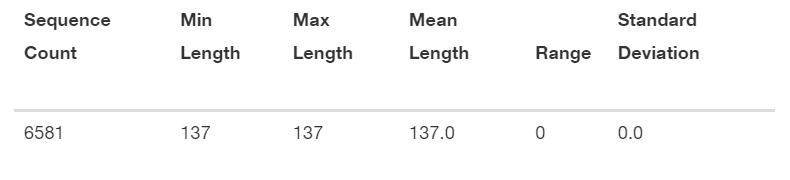
Tabla 2. Secuencias representativas obtenidas a partir de DADA2 y su tamaño.

En la Tabla 2 se puede observar que obtuvimos un total de 6581 ASVs de una longitud de 137, lo cual es bastante alto y difiere con lo encontrado en la tesis de doctorado, en la que se encontraron un total de 5592 ASV. Lo anterior puede deberse a que estamos trabajando con los reads agrupados, single end, mientras que ellos trabajaron con datos pareados. Además ellos cuentan con un total de 443464 lecturas, mientras que nosotros contamos con un total de 779681 lecturas, lo que nos permitió agrupar un mayor número de secuencias según su similitud y por lo tanto llegar a un mayor número de ASVs. 

## Feature classifier 

Los ASVs se encuentran finalmente separados más no identificados, por lo que es necesario establecer cada una de estas agrupaciones a un grupo y nivel taxonómico para estudiar su diversidad. Para lograr esto se utiliza el plug in de QIIME2 llamado feature-classifier, el cuál toma los ASVs y los compara de forma similar a un blast con una base de datos que contiene secuencias consenso para los diferentes grupos taxonómicos de bacterias, y así generar una tabla en un archivo .qza relacionando los ASVs con un grupo taxonómico y cuántos de los mismos corresponden a este. La línea de comando para generar la tabla fue la siguiente:

In [ ]:
qiime feature-classifier classify-consensus-blast --i-reference-reads silva-138-99-seqs.qza --i-reference-taxonomy silva-138-99-tax.qza --i-query representative_seqs.qza --p-strand both --o-classification dada2_rep_taxonomy.qza

Para poder visualizar la tabla en el visualizador de QIIME2 es necesario correr la siguiente línea de comando para obtener un archivo .qzv que se pueda ver en el visualizador:

In [ ]:
qiime metadata tabulate --m-input-file dada2_rep_taxonomy.qza --o-visualization dada2_rep_taxonomy_VIZ.qzv

Para comparar con los resultados de la tesis se generó un gráfico de barras con las diferentes taxas de tal forma que se tenga una vista preliminar de las abundancias, para esto se utiliza la siguiente línea de comando de qiime: 

In [ ]:
qiime taxa barplot --i-table pet-table.qza --i-taxonomy dada2_rep_taxonomy.qza --o-visualization dada2_barplot --m-metadata-file barcodes2.txt

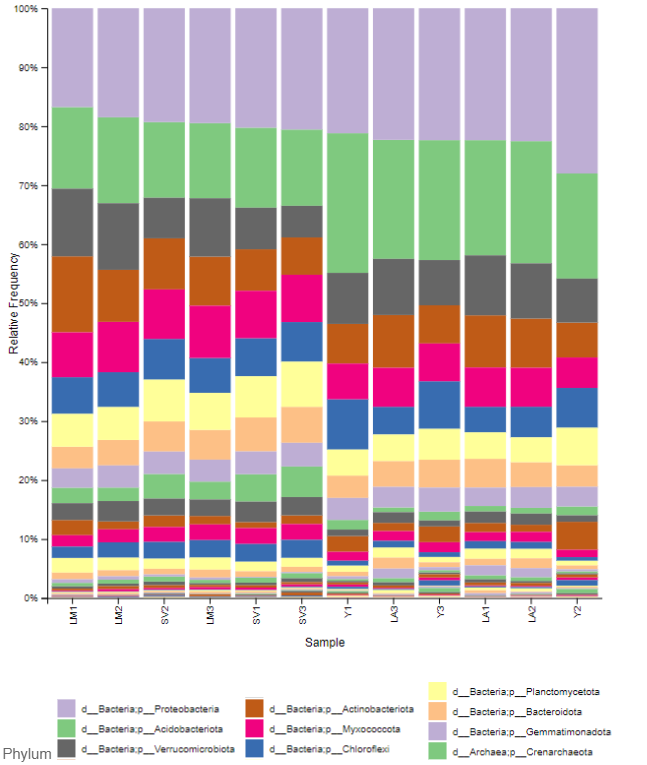
Figura 2. Gráfico de barras para las abundancias por phylum obtenido en el presente trabajo con el comando qiime taxa barplot

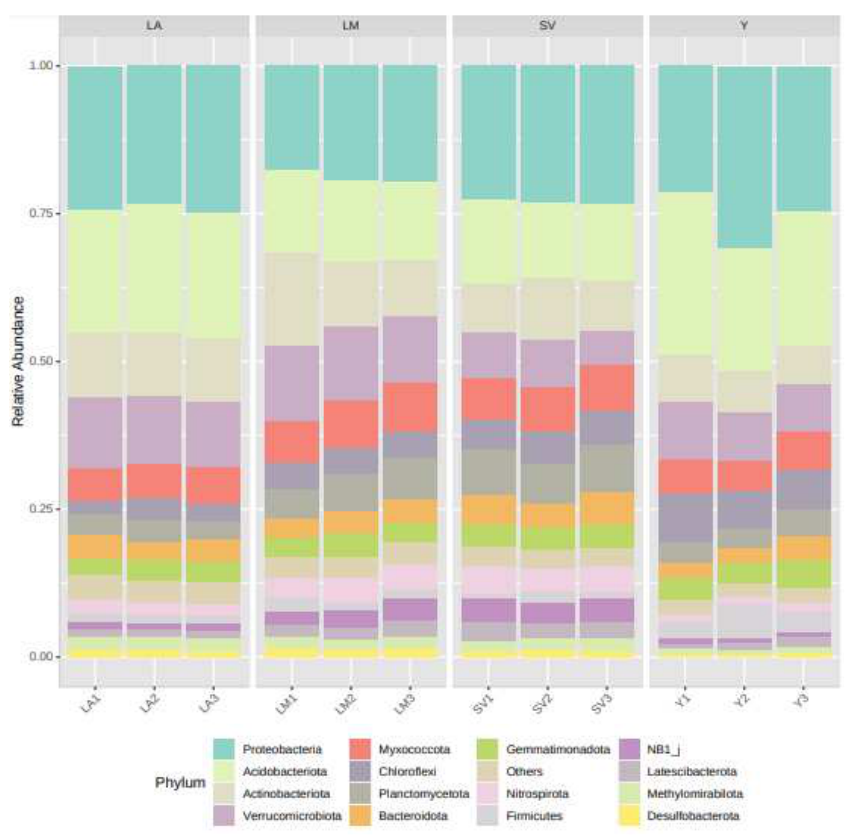
Figura 3. Gráfico de barras para las abundancias por phylum de la tesis doctoral

En la figura 2 se muestra el gráfico de barras con las abundancias de los phyla bacterianos encontrados para la base de datos silva, en total se agruparon los ASVs en aproximadamente 50 phyla bacterianos incluyendo los no asignados. Al comparar estos 50 phyla con los 28 phyla obtenidos en la tesis doctoral (figura 3) se evidencian muchos iguales y otros nuevos para las muestras, como lo es crenarchaeota, esto muy posiblemente debido a la implementación de una versión más actualizada de silva o también debido a que muchos grupos taxonómicos se encuentran en constantes cambios donde se unen o se separan según las investigaciones actuales. Los primeros 5 grupos más predominantes para nuestro pipeline son: proteobacteria, acidobacteria, actinobacteria, verrucomicrobia y myxococcus  al igual que los descubiertos por la tesis doctoral, no obstante las abundancias de estos 5 grupos son diferentes en nuestro procedimiento al tener en la posición 3 de mayor abundancia a verrucomicrobia en vez de actinobacteria como está en la tesis doctoral. Además de esto debido a la aparición de nuevos grupos muchas abundancias de estos grupos son un poco menores en nuestro procedimiento al comparar con la tesis doctoral, cambiando su proporción.

## Construcción del árbol filogenético

Si bien la construcción de un árbol filogenético no es un paso obligatorio en el análisis de datos de QIIME2, este paso es necesario para poder obtener las métricas de alfa y beta diversidad, así como para realizar la normalización de los datos. La construcción de dicho árbol se hace utilizando la herramienta Fasttree, la cual permite la construcción de un unrooted tree y, de ser necesario, se puede determinar una raíz utilizando la rama más larga del árbol, para posteriores análisis.

A continuación se encuentran los comandos utilizados.

Se realizó un alineamiento de secuencias utilizando mafft

In [ ]:
qiime alignment mafft \
  --i-sequences rep-seqs.qza \
  --o-alignment aligned-rep-seqs.qza

Se filtraron los alineamientos para eliminar posiciones altamente variables, pues estas suelen añadir mucho ruido al árbol.

In [ ]:
qiime alignment mask \
  --i-alignment aligned-rep-seqs.qza \
  --o-masked-alignment masked-aligned-rep-seqs.qza

Se creó el árbol filogenético empleando Fasttree.

In [ ]:
qiime phylogeny fasttree \
  --i-alignment masked-aligned-rep-seqs.qza \
  --o-tree unrooted-tree.qza

Se obtuvo un rooted tree empleando la rama más larga del árbol anterior.

In [ ]:
qiime phylogeny midpoint-root \
  --i-tree unrooted-tree.qza \
  --o-rooted-tree rooted-tree.qza

## Normalización de los datos

La rarefacción es un método que ajusta las diferencias en el tamaño de las librerías a lo largo de todas las muestras, para facilitar el proceso de comparación de diversidad entre muestras. La rarefacción implica la selección de un número específico de lecturas que es igual o menor al número de lecturas en la muestra más pequeña, y posteriormente se seleccionan al azar las secuencias excedentes, hasta que el número de secuencias se encuentre en el umbral. Para esto se debe utilizar el árbol filogenético rooted, la tabla de barcodes y la tabla obtenida a partir de DADA2, pues en este último se encuentra el número de ASVs y secuencias que se tienen por muestra, lo cuál va a permitir determinar el número mínimo de lecturas obtenido. A continuación se muestra el comando y los resultados obtenidos.

In [ ]:
qiime diversity alpha-rarefaction --i-table pet-table.qza --i-phylogeny rooted-tree.qza --p-max-depth 23879 --m-metadata-file barcodes2.txt --o-visualization alpha-rarefaction.qzv 

La profundidad escogida fue basándose en el número más bajo de lecturas obtenidas en la muestra, para poder realizar la rarefacción.

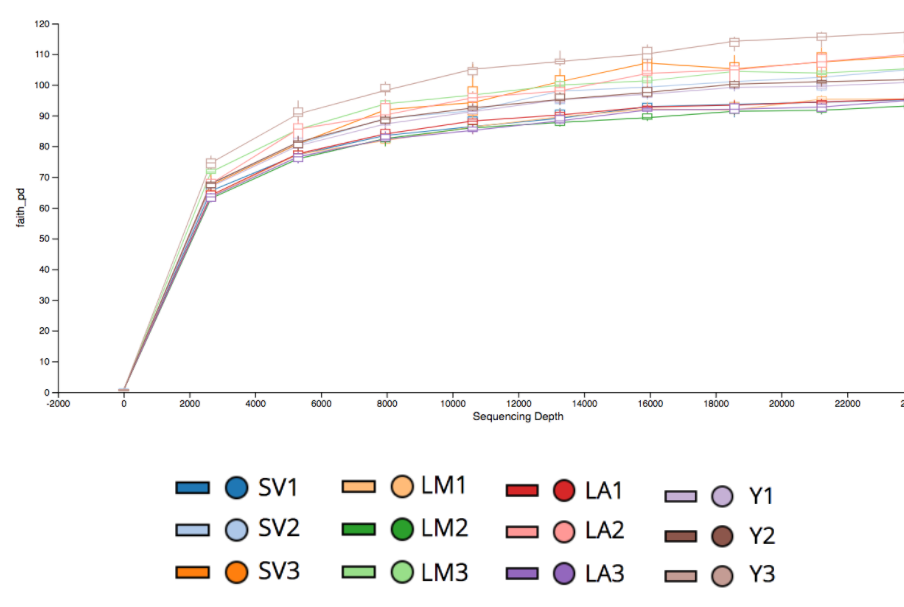
Figura 4. Rarefacción de los datos y determinación del índice de alfa diversidad faith con los reads obtenidos de cada uno de los sitios de muestreo SV, LM, LA y Y.

En la Figura 4 se puede observar que con la rarefacción de datos las muestras que mayor diversidad presentan, después de la normalización de los datos son Y3, SV3 y LA2. Sin embargo, al compararla con la riqueza de especies obtenida con la rarefacción de los datos en la tesis de doctorado en la Figura 5. , se ve que las muestras que más diversidad alfa presentan son la LM, LA2 y SV2. Solo coinciden ambos análisis en LA2. Dicha diferencia puede deberse a la diferencia inicial de reads que se tenían al comenzar el análisis, pues esto ya supone un sesgo, en el que nuestros datos surgen de una cantidad de reads mucho mayor a la de los datos de la tesis de doctorado. 


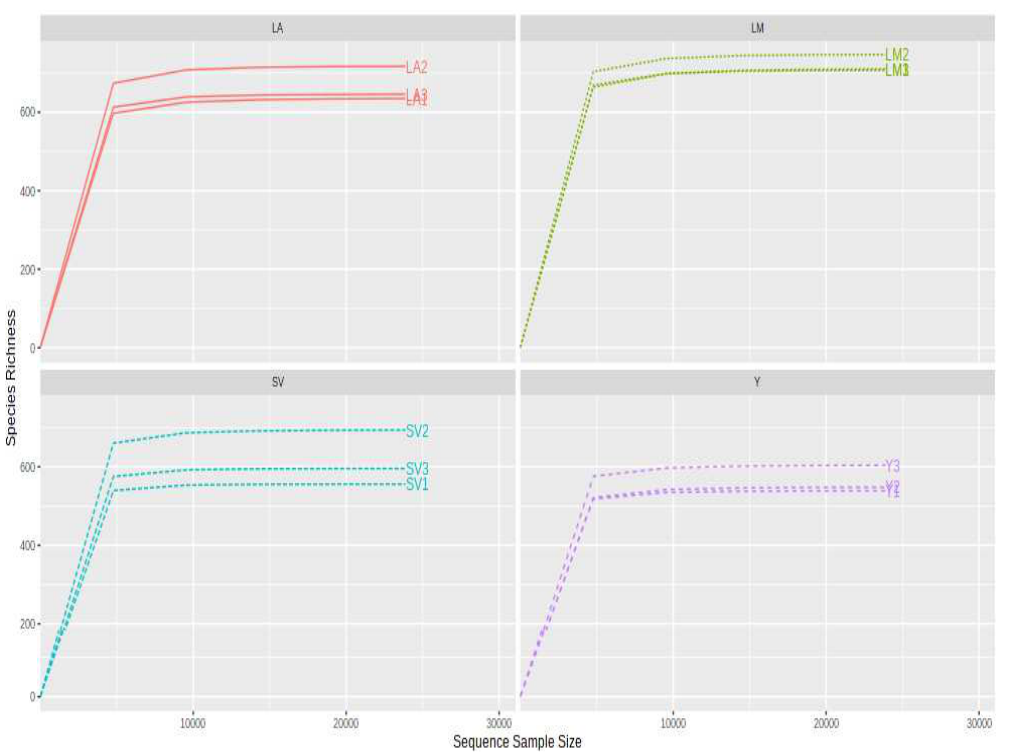
Figura 5. Curva de normalización de datos de cada muestra analizada de la tesis de doctorado.

## Análisis de diversidad

 - Diversidad Alfa: la diversidad alfa se describe como la diversidad media de especies en diferentes sitios o hábitats dentro de una escala local. Para analizar dicha diversidad utilizamos 4 índices que también fueron utilizados en la tesis de doctorado: índice de Shannon, Chao1, Simpson y ASVs observados.
   
    - Índice de Shannon: calcula la riqueza y la diversidad utilizando un logaritmo natural y representa tanto la abundancia como la uniformidad de los taxones presentes. Para poder obtenerla se utilizaron los siguientes comandos: 

In [ ]:
qiime diversity alpha --i-table pet-table.qza --p-metric shannon --o-alpha-diversity shannon_index.qza

Y para obtener la gráfica según cada muestra se utilizó el siguiente comando:

In [ ]:
qiime diversity alpha-group-significance --i-alpha-diversity shannon_index.qza --m-metadata-file barcodes2.txt --o-visualization shannon_index.qzv

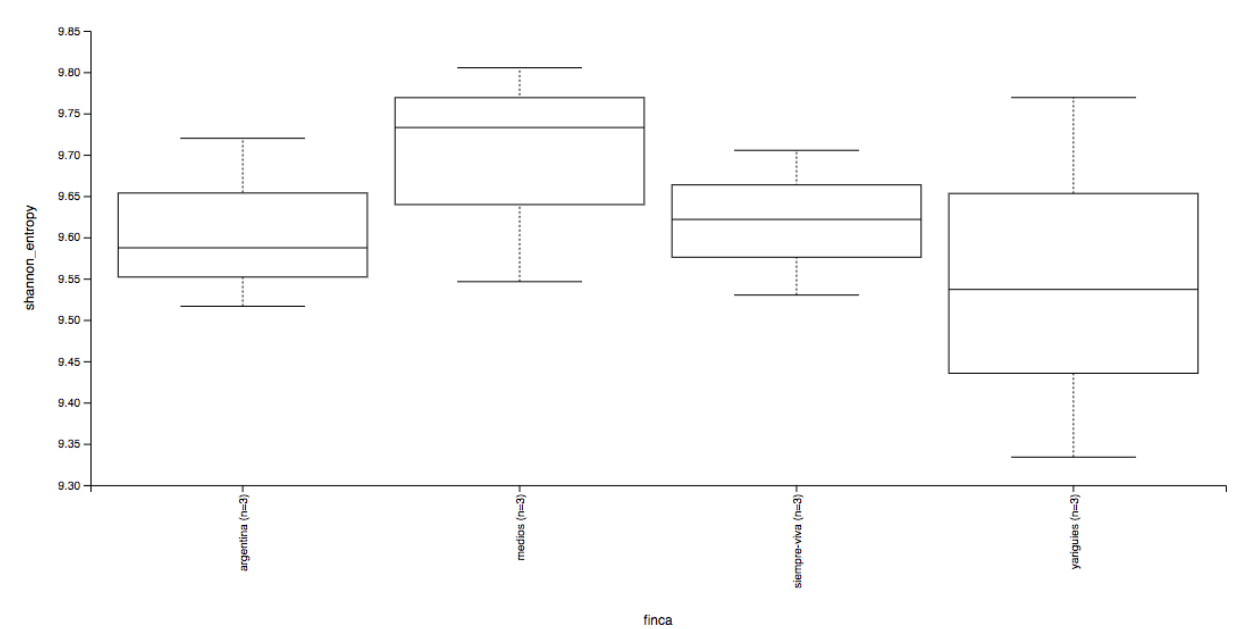
Figura 6. Alfa diversidad: índice de Shannon para las muestras analizadas, divididas por finca.

- Índice Chao1: Calcula el intervalo de confianza chao1. Intervalo de confianza para estimador de riqueza, Chao1. Para poder obtenerla se utilizaron los siguientes comandos: 

In [ ]:
qiime diversity alpha --i-table pet-table.qza --p-metric chao1 --o-alpha-diversity chao1_index.qza

Y para obtener la gráfica según cada muestra se utilizó el siguiente comando:

In [ ]:
qiime diversity alpha-group-significance --i-alpha-diversity chao1_index.qza --m-metadata-file barcodes2.txt --o-visualization chao1_index.qzv

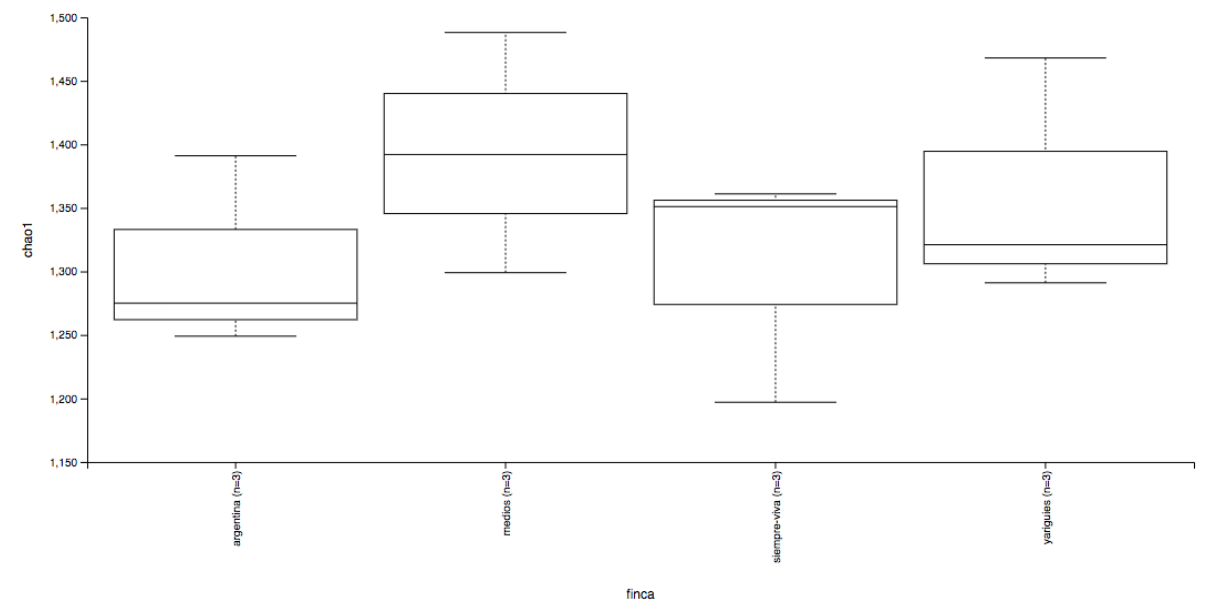
Figura 7. Alfa diversidad: índice Chao1 para las muestras analizadas, divididas por finca.

- Índice Simpson: Mide la abundancia relativa de las diferentes especies que componen la riqueza de la muestra. Para poder obtenerla se utilizaron los siguientes comandos:

In [ ]:
qiime diversity alpha --i-table pet-table.qza --p-metric simpson --o-alpha-diversity simpson_index.qza

Y para obtener la gráfica según cada muestra se utilizó el siguiente comando:

In [ ]:
qiime diversity alpha-group-significance --i-alpha-diversity simpson_index.qza --m-metadata-file barcodes2.txt --o-visualization simpson_index.qzv

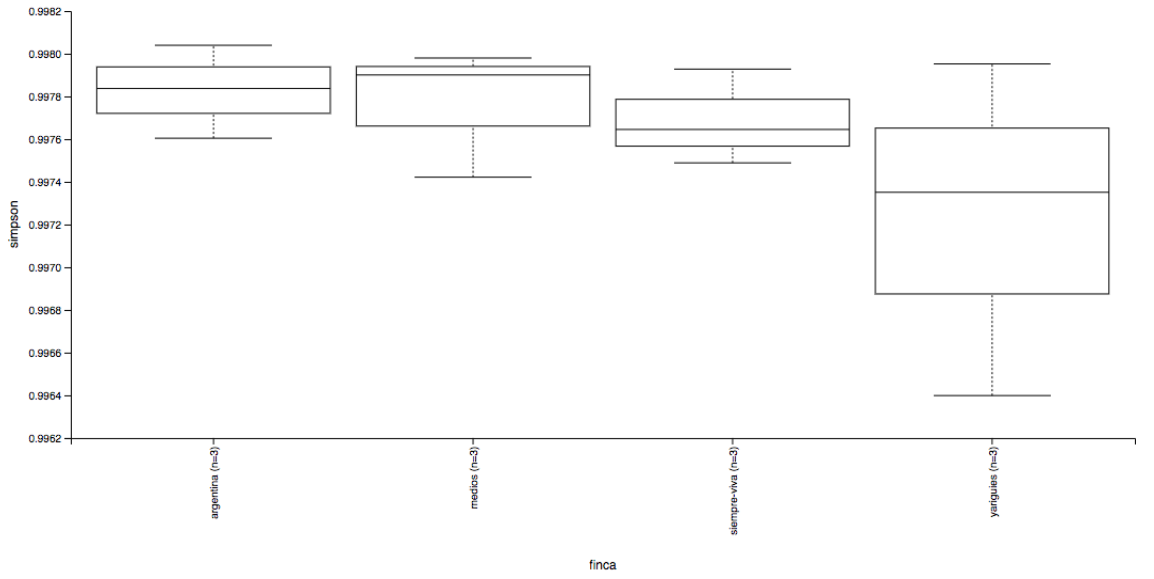
Figura 8. Alfa diversidad: índice de Simpson para las muestras analizadas, divididas por finca.

- Índice de ASVs observados: calcula la abundancia relativa de ASV que componen cada muestra. Para poder obtenerlo se utilizaron los siguientes comandos:

In [ ]:
qiime diversity alpha --i-table pet-table.qza --p-metric observed_features --o-alpha-diversity observed_index.qza

Y para obtener la gráfica según cada muestra se utilizó el siguiente comando:

In [ ]:
qiime diversity alpha-group-significance --i-alpha-diversity observed_index.qza --m-metadata-file barcodes2.txt --o-visualization observed_index.qzv

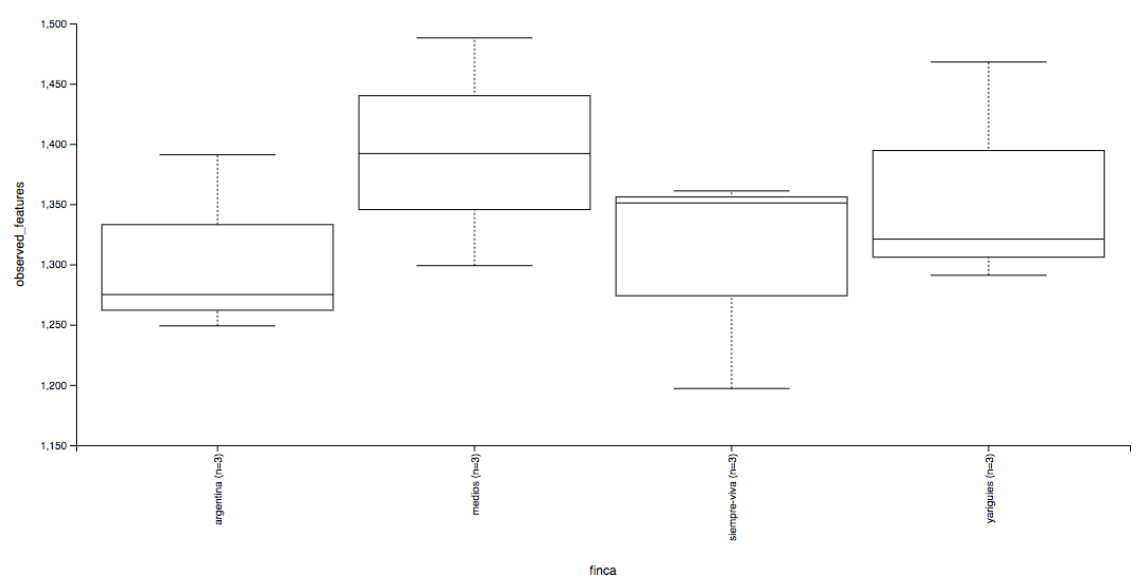
Figura 9. Alfa diversidad: ASVs observados para las muestras analizadas, divididas por finca.

Posteriormente se realizó la comparación entre cada una de las métricas obtenidas y las obtenidas en el paper. 

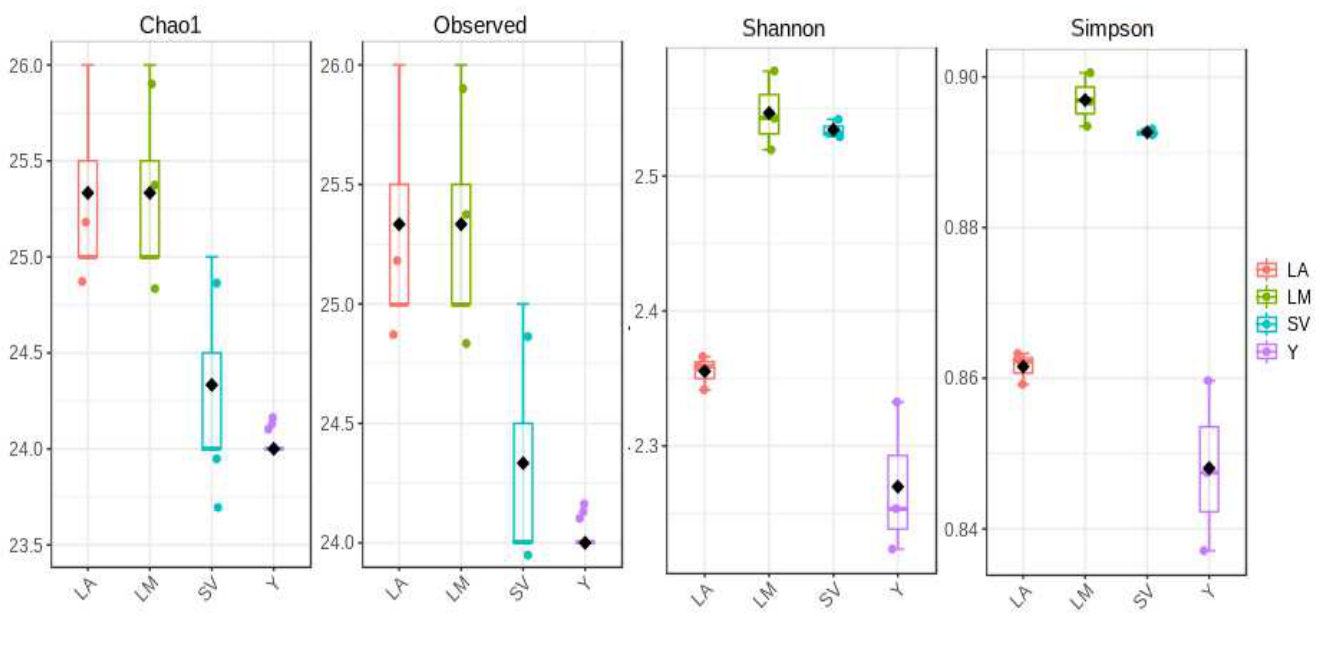
Figura 10. Alfa diversidad de ASVs para las muestras de suelos analizados: Chao1, ASV observados, Shannon y Simpson, respectivamente. 

Para el índice de Shannon, entre mayor sea el valor del índice, mayor será la diversidad de especies para una comunidad en particular. Por lo tanto si comparamos la Figura 6 y la Figura 10, podemos observar que en nuestro análisis se obtuvo una mayor diversidad, con un índice de más o menos 9, mientras que en el análisis de la tesis de doctorado se obtuvo un índice de más o menos 2. 

Para el índice de Chao1, se basa en las especies que sólo están representadas por pocos individuos en una muestra. Al observar la Figura 7 y la Figura 10, vemos que con nuestro método de análisis se obtuvo un valor muchísimo más alto. Sin embargo, lo anterior puede deberse a que nosotros contamos inicialmente con muchísimos más reads, y también con más ASVs, lo cuál permite que se agrupen en mayor medida, pequeños grupos de secuencias que corresponden a especies poco representadas en la muestra. 
En el caso del índice de Simpson, mientras más se acerque a 1 el valor del índice, se tendrá una mayor diversidad. Al observar la Figura 8 y la Figura 10, podemos ver que en nuestro análisis estamos más o menos en los valores de 1, mientras que en la tesis doctoral, los valores son de alrededor de 0.8 y 0.9. Ambos valores se encuentran bastante cerca e indican una alta diversidad, sin embargo, habría que realizar pruebas estadísticas para ver si hay una diferencia significativa. 
Por último, se tienen los ASV observados. Al observar la Figura 9 y la Figura 10, podemos observar que ocurre algo similar a lo ocurrido con el índice Chao1 y puede tener una explicación muy similar. Como se contó con más secuencias, se contó con más ASV y por lo tanto una mayor cantidad de posibles clasificaciones taxonómicas fue obtenida, lo cual tiene un impacto en la diversidad de la muestra.


- Beta diversidad: es una medida de la tasa de cambio en especies entre dos comunidades adyacentes, y por lo tanto refleja la diferencia de composición de las dos comunidades, dando fe de la heterogeneidad del paisaje. En este caso se realizó un análisis de disimilitud de Bray-Curtis, que es una estadística que se utiliza para cuantificar la diferencia de composición entre dos sitios diferentes, según los recuentos de cada sitio. Esta métrica da un valor entre 0 y 1 y posteriormente lo multiplica por 100. Si es 0, los dos sitios de muestreo comparten todas las especies, pero si es 1, los dos sitios de muestreo no comparten ninguna especie. 

En las Figuras 11 y 12 podemos observar que este índice agrupó a las muestras según la finca de la cuál provienen, lo cuál quiere decir que dentro de las mismas fincas, las muestras suelen compartir casi todas las especies. Sin embargo, se logra percibir una marcada diferencia entre las fincas LM y SV con las fincas LA y Y, pues la disimilitud de Bray-Curtis aumenta, y por lo tanto las muestras comparten menos especies. 


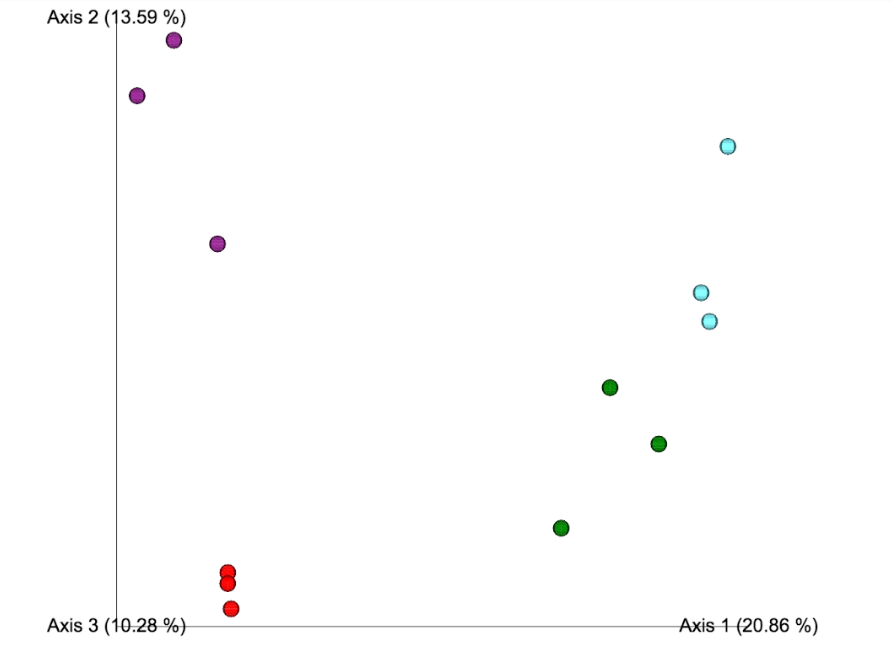
Figura 11. Disimilitud de Bray-Curtis basándonos en el análisis realizado en este trabajo. Los puntos morados corresponden a la finca Y, los rojos a la finca LA, los azules a la finca SV y los verdes a la finca LM.

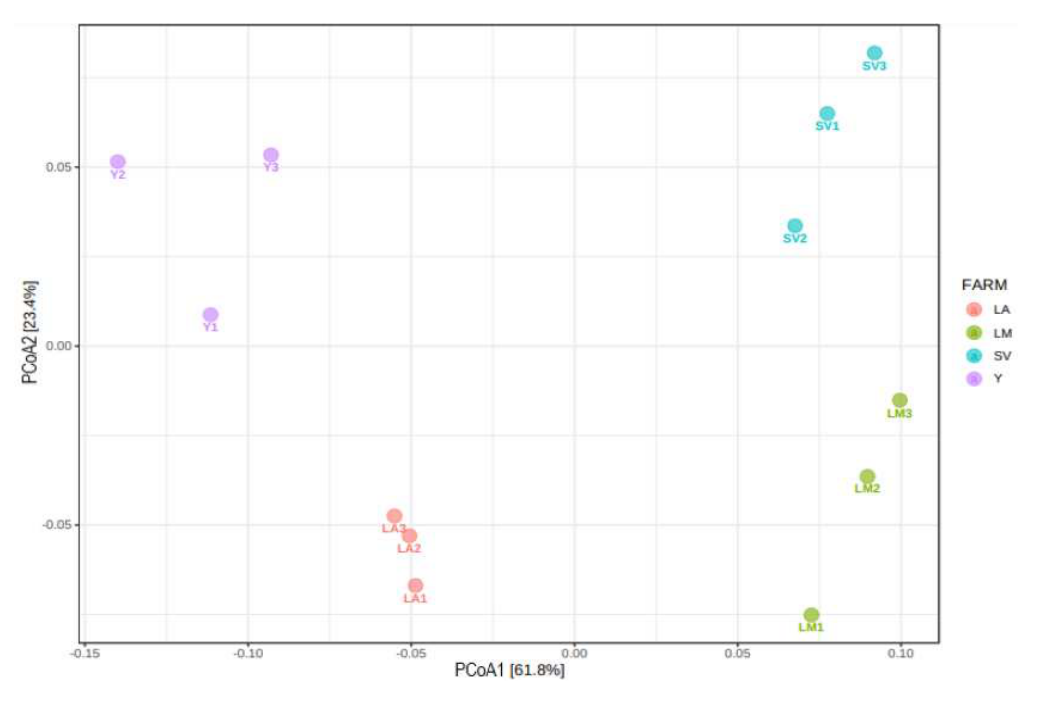
Figura 12. Disimilitud de Bray-Curtis obtenida en la tesis de doctorado